# A quick (and over-simplified) introduction to spiking neurons

Author: Sadique Sheik

Spiking neural networks are considered to be the `third generation` of neural networks preceeded by McCUlloch-Pitts threshold neurons (`first generation`) which produced digital outputs and Artificial Neural Networks with continuous activations, like sigmoids and hyperbolic tangets, (`second generation`) that are commonly used these days.


## Artificial Neuron (AN) Model

The transfer function of a neuron in ANNs can be expressed as follows.

$$\vec{y} = f(W.\vec{x} + b)$$

where $f$ is typically a non linear activation function such as a `signoid` or `hyperbolic tangent` function.


> Note that the output directly depends on the inputs. The neuron does not have an internal state that would affect its output.


This is where spiking neurons and spiking neural networks (SNNs) come into play. They add an additional dependence on the current `state` of the neuron.

## Leaky Integrate and Fire (LIF)  model

One of the simplest models of spiking neurons is the Leaky Integrate and Fire (LIF) neuron model, where the state of the neuron, typically the `membrane potential` $v$,  is dependent on its previous state in addition to its inputs. The dynamics of this state can be described as follows.

$$\tau \dot{v} = - v(t) + R \cdot \big(I_{syn} + I_{bias}\big)$$

where $\tau$ is the membrane time constant, which determines how much the neuron depends on its previous states and inputs and therefore defines the neuron's memory. The linear equation above describes the dynamics of a system with `leaky` dynamics ie over time, the membrane potential $v$ slowly `leaks` to $0$. This is why the neuron model is referred to as a `Leaky Integrate and Fire Neuron model`.


> Note that there is an additional notion of time, which does not occor explicitly in an artificial neuron model.


$I_{syn} := W.\vec{x}$ is the weighted sum of all the input snaptic contributions and $I_{bias}$ is a constant bias. The constant resistance $R$ has unity value and only serves to match units between membrane potential and currents.

The output of this neuron is binary and instantaneous. It is $1$ only when $v$ reaches a threshold value $v_{th}$ upon which the membrane potential is immediately reset to a reset value $v_{reset} < v_{th}$. The dynamics of $v$ can be expressed as:

$$
v(t+\delta) = 
\left\{
\begin{array}{}
v_{reset},& \text{if } v(t) \geq v_{th} \\ 
v(t),& \text{otherwise} 
\end{array}
\right.
$$


This instantanious output of $1$ is typically referred to as `spike` at time $t$. A series of such spikes will hence forth be referred to as $s(t)$.

$$
s(t) = 
\left\{
\begin{array}
1,& \text{if } v(t)\geq v_{th}\\
0,& \text{otherwise}
\end{array}
\right.
$$

In [1]:
# A simple LIF neuron simulation for `t_sim=100` time steps

import numpy as np

t_sim = 100 # ms
tau = 20 # ms
v_th = 10.0 # Membrane spiking threshold
v_reset = 0 # Resting potential
vmem = [0] # Initial membrane potential
i_syn = 11 # unit free, assuming constant synaptic input
st = [] # Spike train
for t in range(t_sim):
    # Check threshold
    if vmem[t] >= v_th:
        vmem[t] = v_reset
        st.append(t)
    # Membrane dynamics
    dv = (1/tau)*(-vmem[t] + i_syn)
    # Save data
    vmem.append(vmem[t] + dv)
    
print(f'Neuron spikes {len(st)} times at the following simulation time steps :{st}')

Neuron spikes 2 times at the following simulation time steps :[47, 94]


We can plot the membrane potential trace to see how it evolves over time.

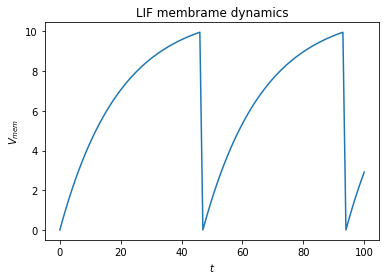

In [2]:
%matplotlib inline
# Plot membrane potential
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(t_sim+1), vmem)
plt.title('LIF membrame dynamics')
plt.xlabel('$t$')
_=plt.ylabel('$V_{mem}$')

## Constant-leak Integrate and Fire (IAF) model

The LIF model describes a dynamical system where $v$ is continually being updated. While this is a realistic description of most systems in the real world, for the sake of simplicity (and ease of computation on a digital system like a PC), if we assume that there is only a constant `leak` or (no `leak` if = 0) in its membrane potential, such a model will hence forth be referred to as an `IAF` mode and is described by the following equation:

$\tau \dot{v} = - v_{leak} + R \cdot \big(I_{syn} + I_{bias}\big)$

with $v_{leak}$ being the constant `leak`. Because it is a constant, it can be joined with the bias, such that the equation for $v$ can be simplified to

$\tau \dot{v} = R \cdot \big(I_{syn} + \tilde{I}_{bias}\big)$

with $\tilde{I}_{bias} := I_{bias} + \frac{v_{leak}}{R}$.

In [3]:
## IAF model in SINABS
import torch
import sinabs.layers as sl


# Define a neuron in 'SINABS'
neuron = sl.SpikingLayer()


# Set a constant bias current to excite the neuron
inp = torch.zeros(t_sim, 1)+0.025

# Membrane potential trace
vmem = [0]

# Output spike raster
st = [] # Spike train
for t in range(t_sim):
    with torch.no_grad():
        out = neuron(inp[t:t+1])
        # Check if there is a spike
        if (out!=0).any():
            st.append(t)
        # Record membrane potential
        vmem.append(neuron.state[0])

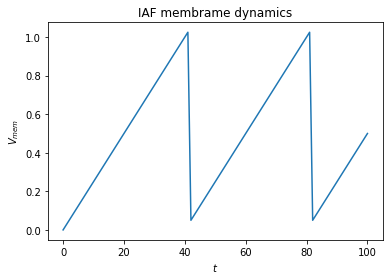

In [4]:
# Plot membrane potential
plt.figure()
plt.plot(range(t_sim+1), vmem)
plt.title('IAF membrame dynamics')
plt.xlabel('$t$')
plt.ylabel('$V_{mem}$');

## Activation function

The activation functions for artificial neuron models are fairly straight forward to understand. Given an input $x$ and an activation function $\Phi$ the output $y$ of this neuron would be:
 
$$y = \Phi (W.x + b)$$

For a spiking neuron model such as `IAF`, what would this activation function look like? Defining such a function is fairly complex because the output $y$ doesn't just depend on input $x$ but also its state. More over the output of these neurons is a series of spikes $s(t)$ ie series of Dirac delta functions.

One way to interpret the resonse of the spiking neuron to its inputs is to look at the number of spikes the neuron produces within a time window. For instance, in the example above we can say that the neruon produces an output of $2$ for a `bias` of $0.025$ (which was our choice of `bias` parameter) and input `zero`. 

```
We will refer to this `interpretation` of spikes as `rate coding` because we are looking at spike rate of neurons as our information medium.
```

With this `rate coding` interpretation of spiking neurons let us look at what the transfer function $\Phi$ looks like for `IAF` neuron model.

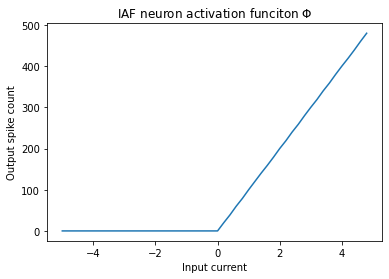

In [5]:
# IAF neuron activation function
import numpy as np

# Define a neuron in 'SINABS'
neuron = sl.SpikingLayer()

# Simulation time
t_sim = 100


spike_rates_out = []

biases = np.arange(-5, 5, 0.2) # Range of inputs to iterate over

for bias in biases:
    # Reset the neuron
    neuron.reset_states()
    # Set a constant bias current to excite the neuron
    inp = torch.zeros(t_sim,1)+bias
    # Output spike raster
    with torch.no_grad():
        # Simulate neuron for t_sim timesteps
        out = neuron(inp)
        """
        Notice that we can do the entire simulation in one line,
        unlike the code block earlier where we had a for loop to iterate over all time steps.
        """
        spike_rates_out.append(out.sum())

plt.figure()
plt.plot(biases, spike_rates_out)
plt.title("IAF neuron activation funciton $\Phi$")
plt.ylabel("Output spike count")
plt.xlabel("Input current");

## IAF neuron's transfer function is equivalent to ReLU

The above figure must look familiar if you have worked with ANNs, especially deep learning models; the activation function of a `IAF neuron` can be interpreted as that of a `Rectified Linear Unit (ReLU)`'s activation function.

__This observation is the entry point to porting Deep Learning (DL) models consisting of layers with ReLU (which is a majority) activations to SNNs.__

## References

- Farabet C, Paz R, Pérez-Carrasco J, Zamarreño C, Linares-Barranco A, LeCun Y, Culurciello E, Serrano-Gotarredona T, Linares-Barranco B. Comparison between frame-constrained fix-pixel-value and frame-free spiking-dynamic-pixel convNets for visual processing. Frontiers in neuroscience. 2012 Apr 12;6:32.
- Neil D, Pfeiffer M, Liu SC. Learning to be efficient: Algorithms for training low-latency, low-compute deep spiking neural networks. InProceedings of the 31st annual ACM symposium on applied computing 2016 Apr 4 (pp. 293-298). ACM.
- Rueckauer B, Lungu IA, Hu Y, Pfeiffer M, Liu SC. Conversion of continuous-valued deep networks to efficient event-driven networks for image classification. Frontiers in neuroscience. 2017 Dec 7;11:682.
- Sengupta A, Ye Y, Wang R, Liu C, Roy K. Going deeper in spiking neural networks: VGG and residual architectures. Frontiers in neuroscience. 2019;13.
    